In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator
from ta.volatility import BollingerBands
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import datetime

In [2]:
# Project time frame
start_date = "2020-01-01"
end_date = "2025-05-01"

# Benchmark index
benchmark_symbol = "^GSPC"

# Top 10 symbols from each sector (replace with your actual tickers if needed)
sectors = {
    "Technology": ["AAPL", "MSFT", "NVDA", "AVGO", "ADBE", "CRM", "AMD", "CSCO", "INTC", "ORCL"],
    # "Communication": ["GOOGL", "META", "NFLX", "TMUS", "DIS", "VZ", "T", "CHTR", "CMCSA", "WBD"],
    # "Health": ["JNJ", "PFE", "ABBV", "LLY", "MRK", "TMO", "BMY", "UNH", "ABT", "CVS"],
    # "Financials": ["JPM", "BAC", "WFC", "C", "GS", "MS", "AXP", "USB", "BK", "SCHW"],
    # "Defensive": ["PG", "KO", "PEP", "WMT", "COST", "CL", "MO", "KMB", "MDLZ", "KR"],
    # "Cyclical": ["AMZN", "HD", "LOW", "MCD", "NKE", "SBUX", "BKNG", "TGT", "EBAY", "GM"],
    # "Property": ["PLD", "AMT", "CCI", "EQIX", "DLR"benchmark_symbol "SPG", "O", "PSA", "VTR", "EXR"],
    "Benchmark": [benchmark_symbol]
}

# Flatten list of all tickers
all_symbols = [symbol for group in sectors.values() for symbol in group]

### Load from CSV

In [3]:
# Load dataset from CSV
import os

if os.path.exists("stock_sector_data.csv"):
    stock_df = pd.read_csv("stock_sector_data.csv", parse_dates=["Date"])
    print("Loaded dataset from CSV.")
else:
    print("CSV file not found. Please run the download step.")


Loaded dataset from CSV.


### Feature Engineering — Add Technical Indicators


In [4]:
def add_technical_indicators(df):
    result = []

    for symbol in df["Symbol"].unique():
        sub = df[df["Symbol"] == symbol].sort_values("Date").copy()

        # Momentum: past 1-week and 4-week returns
        sub["Return_1w"] = sub["Close"].pct_change(1*7)
        sub["Return_4w"] = sub["Close"].pct_change(4*7)

        # Volatility: Rolling std dev
        sub["Volatility_4w"] = sub["Close"].rolling(window=4).std()
        
        # Moving averages
        sub['MA5'] = sub['Close'].rolling(window=5).mean()
        sub['MA20'] = sub['Close'].rolling(window=20).mean()
        sub['MA50'] = sub['Close'].rolling(window=50).mean()
        
        # Volume indicators
        sub['Volume_Change'] = sub['Volume'].pct_change()
        sub['Volume_MA5'] = sub['Volume'].rolling(window=5).mean()
        
        # MACD
        sub["MACD"] = MACD(close=sub["Close"]).macd()
        sub["MACD_Signal"] = MACD(close=sub["Close"]).macd_signal()

        # RSI
        sub["RSI"] = RSIIndicator(close=sub["Close"], window=14).rsi()

        # SMAbenchmark_symbol
        # Bollinger Bands
        bb = BollingerBands(close=sub["Close"], window=20)
        sub["BB_Upper"] = bb.bollinger_hband()
        sub["BB_Lower"] = bb.bollinger_lband()

        result.append(sub)

    features_df = pd.concat(result).reset_index(drop=True)
    return features_df

features_df = add_technical_indicators(stock_df)
features_df = features_df.dropna()
features_df.head()


,Date,Open,High,Low,Close,Volume,Symbol,Sector,Return_1w,Return_4w,...,MA5,MA20,MA50,Volume_Change,Volume_MA5,MACD,MACD_Signal,RSI,BB_Upper,BB_Lower
49,2020-12-09,121.638536,124.930291,117.360238,124.910751,519769400,AAPL,Technology,0.098633,0.587574,...,119.077415,114.712808,91.657319,0.251944,456726820.0,7.837342,8.112576,65.308887,127.235772,102.189844
50,2020-12-16,124.451689,131.289157,120.583629,128.817902,675266300,AAPL,Technology,0.196193,0.538949,...,121.517421,115.816616,92.788847,0.299165,499281440.0,8.285368,8.147134,67.545593,129.196984,102.436247
51,2020-12-23,129.091366,135.567413,127.743404,131.738434,388687300,AAPL,Technology,0.164979,0.537676,...,125.365935,117.080563,93.909591,-0.424394,483844320.0,8.774942,8.272695,69.146905,131.427468,102.733658
52,2020-12-30,132.431991,132.832475,123.816781,127.968094,436535500,AAPL,Technology,0.097328,0.434782,...,126.985439,117.844725,94.936093,0.123102,487085640.0,8.757744,8.369705,64.708118,132.789327,102.900122
53,2021-01-06,124.754470,129.550468,123.445579,125.809395,562160000,AAPL,Technology,0.118347,0.417268,...,127.848915,118.049360,95.913997,0.287776,516483700.0,8.472263,8.390217,62.244416,133.309190,102.789530


### Create Outperformance Label

In [5]:
def create_outperformance_labels(features_df, benchmark_df):
    # Calculate future return for S&P 500
    benchmark_df["Benchmark_Return_Next"] = benchmark_df["Close"].pct_change().shift(-1)

    # Ensure 'Date' columns are of the same type
    features_df["Date"] = pd.to_datetime(features_df["Date"])
    benchmark_df["Date"] = pd.to_datetime(benchmark_df["Date"])

    # Merge benchmark return into stock data
    df = features_df.merge(benchmark_df[["Date", "Benchmark_Return_Next"]], on="Date", how="left")

    # Calculate stock return next week
    price_col = "Adj Close" if "Adj Close" in df.columns else "Close"
    df["Stock_Return_Next"] = df.groupby("Symbol")[price_col].pct_change().shift(-1)

    # Label = 1 if stock outperforms benchmark, else 0
    df["Label"] = (df["Stock_Return_Next"] > df["Benchmark_Return_Next"]).astype(int)

    return df

# Load benchmark data from CSV
benchmark_df = pd.read_csv("stock_sector_data.csv", usecols=["Date", "Symbol", "Close"])
benchmark_df = benchmark_df[benchmark_df["Symbol"] == benchmark_symbol].reset_index(drop=True)

labeled_df = create_outperformance_labels(features_df, benchmark_df)
labeled_df[["Date", "Symbol", "Sector", "Stock_Return_Next", "Benchmark_Return_Next", "Label"]].tail()


,Date,Symbol,Sector,Stock_Return_Next,Benchmark_Return_Next,Label
16325,2025-04-02,^GSPC,Benchmark,0.083058,0.083058,0
16326,2025-04-09,^GSPC,Benchmark,-0.020174,-0.020174,0
16327,2025-04-16,^GSPC,Benchmark,0.051642,0.051642,0
16328,2025-04-23,^GSPC,Benchmark,0.001480,0.001480,0
16329,2025-04-30,^GSPC,Benchmark,NaN,NaN,0


### Train/Test Split & Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocess_data(df):
    # Drop rows where the label is missing (NaN due to shifting)
    df = df.dropna(subset=["Label"])
    
    # Fill remaining missing values with median (safe for numeric features)
    df = df.fillna(df.median(numeric_only=True))

    # Keep only numeric feature columns
    exclude_cols = ['Date', 'Symbol', 'Sector', 'Label', 'Stock_Return_Next', 'Benchmark_Return_Next']
    feature_columns = [col for col in df.columns if col not in exclude_cols and df[col].dtype != 'object']
    
    X = df[feature_columns]
    y = df["Label"].astype(int)  # Ensure label is int

    # Optional: Scaling (not strictly necessary for Random Forest)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y

# Split the data: train up to 2023, test after
train_data = labeled_df[labeled_df["Date"] < "2023-01-01"]
test_data = labeled_df[labeled_df["Date"] >= "2023-01-01"]

X_train, y_train = preprocess_data(train_data)
X_test, y_test = preprocess_data(test_data)

Feature columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Return_1w', 'Return_4w', 'Volatility_4w', 'MA5', 'MA20', 'MA50', 'Volume_Change', 'Volume_MA5', 'MACD', 'MACD_Signal', 'RSI', 'BB_Upper', 'BB_Lower']
Feature columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Return_1w', 'Return_4w', 'Volatility_4w', 'MA5', 'MA20', 'MA50', 'Volume_Change', 'Volume_MA5', 'MACD', 'MACD_Signal', 'RSI', 'BB_Upper', 'BB_Lower']


### Train Random Forest Classifier

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluation: Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:")
print(roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))


Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.55      0.54      4540
           1       0.48      0.46      0.47      4122

    accuracy                           0.51      8662
   macro avg       0.51      0.51      0.50      8662
weighted avg       0.51      0.51      0.51      8662

ROC-AUC Score:
0.5143680786667436


### Feature Importance Plot

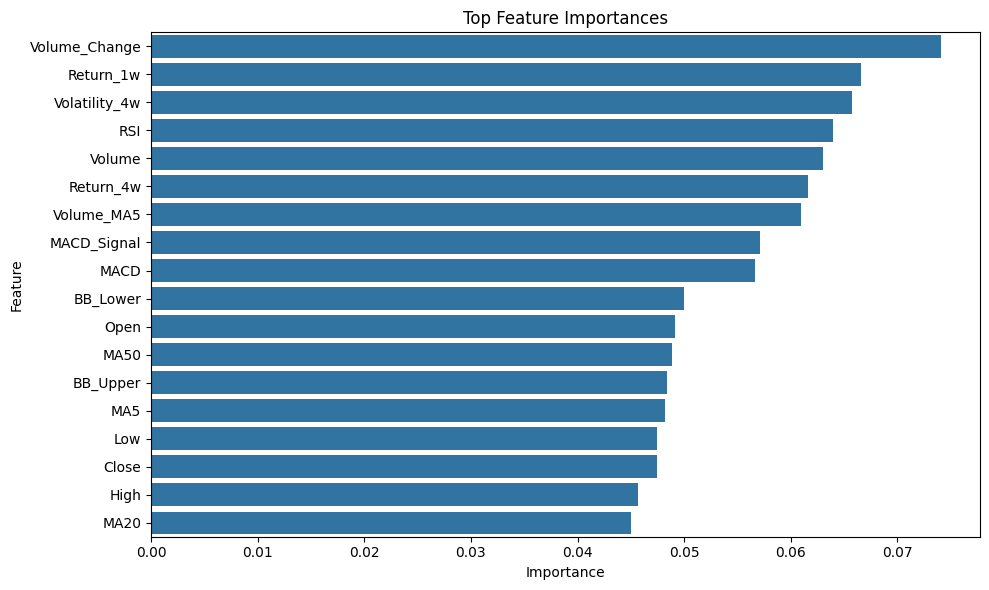

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

exclude_cols = ['Date', 'Symbol', 'Sector', 'Label', 'Stock_Return_Next', 'Benchmark_Return_Next']

# Get feature importances and names
feature_columns = [col for col in train_data.columns if col not in exclude_cols and train_data[col].dtype != 'object']
importances = rf_model.feature_importances_

# Create DataFrame for plotting
feat_imp_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
plt.title('Top Feature Importances')
plt.tight_layout()
plt.show()

In [12]:
feat_imp_df.sort_values(by='Importance', ascending=False).head(10)

,Feature,Importance
11,Volume_Change,0.074045
5,Return_1w,0.066549
7,Volatility_4w,0.065731
15,RSI,0.063955
4,Volume,0.063006
6,Return_4w,0.061595
12,Volume_MA5,0.060945
14,MACD_Signal,0.057156
13,MACD,0.056627
17,BB_Lower,0.050033


### Correlation Analysis

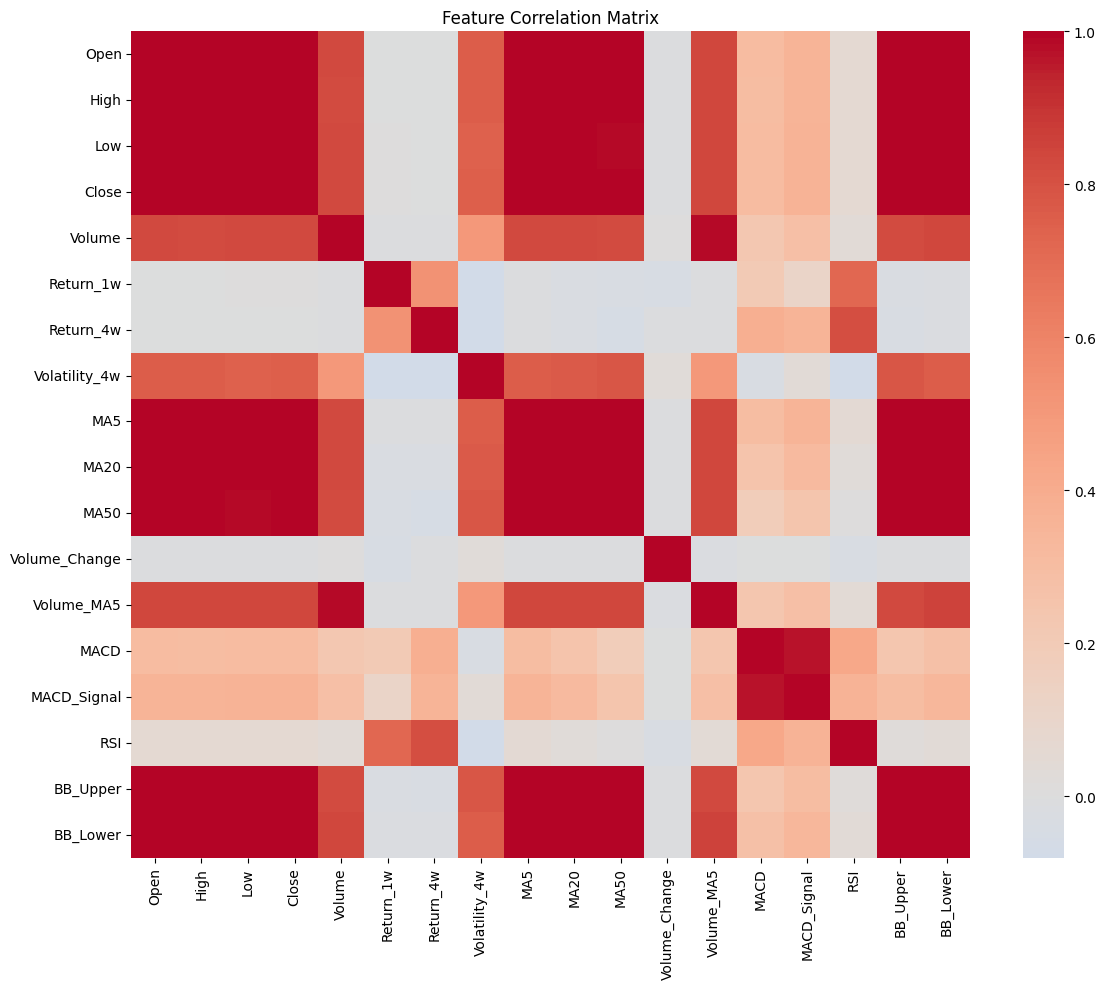

In [10]:
# Compute correlation matrix on the training features
exclude_cols = ['Date', 'Symbol', 'Sector', 'Label', 'Stock_Return_Next', 'Benchmark_Return_Next']

numeric_cols = [col for col in train_data.columns if col not in exclude_cols and train_data[col].dtype != 'object']
corr_matrix = train_data[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

### Reduce Multicollinearity

In [13]:
selected_features = [
    'Volume_Change',
    'Return_1w',
    'Return_4w',
    'Volatility_4w',
    'Volume',
    'Volume_MA5'
]

### Train/Test Split & Preprocessing after Reduce Multicollinearity

In [14]:
def preprocess_data(df):
    # Drop rows where the label is missing (NaN due to shifting)
    df = df.dropna(subset=["Label"])
    
    # Fill remaining missing values with median (safe for numeric features)
    df = df.fillna(df.median(numeric_only=True))

    # Use only selected features
    X = df[selected_features]
    y = df["Label"].astype(int)  # Ensure label is int

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y

# Split the data: train up to 2023, test after
X_train, y_train = preprocess_data(train_data)
X_test, y_test = preprocess_data(test_data)


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluation: Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:")
print(roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))


Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.51      0.52      4540
           1       0.48      0.49      0.48      4122

    accuracy                           0.50      8662
   macro avg       0.50      0.50      0.50      8662
weighted avg       0.50      0.50      0.50      8662

ROC-AUC Score:
0.5055972625666083


In [17]:
from itertools import combinations
from sklearn.metrics import f1_score
from joblib import Parallel, delayed
import time

import matplotlib.pyplot as plt

# Store the best combination and its score
best_combination = None
best_score = 0
scores = []

# Function to evaluate a combination of features
def evaluate_combination(combo):
    # Preprocess data with the current combination of features
    start_time = time.time()
    X_train_combo = train_data[list(combo)]
    X_test_combo = test_data[list(combo)]

    rf_model = RandomForestClassifier(
        max_depth=10,
        max_features=None,
        min_samples_leaf=2,
        min_samples_split=2,
        n_estimators=1000,
        bootstrap=False
    )
    # Train the model
    rf_model.fit(X_train_combo, y_train)

    # Predict and evaluate
    y_pred_combo = rf_model.predict(X_test_combo)
    score = f1_score(y_test, y_pred_combo)
    presision = classification_report(y_test, y_pred_combo, output_dict=True)["1"]["precision"]
    
    print(f"Combination: {combo}, F1 Score: {score}, Precision: {presision}")
    print(f"Time taken: {time.time() - start_time:.2f} seconds")

    return combo, score

# Run combinations in parallel
results = Parallel(n_jobs=-1)(
    delayed(evaluate_combination)(combo)
    for r in range(1, len(selected_features) + 1)
    for combo in combinations(selected_features, r)
)

# Collect and rank results
scores = sorted(results, key=lambda x: x[1], reverse=True)
best_combination, best_score = scores[0]

print(f"Best combination: {best_combination}")
print(f"Best F1 Score: {best_score}")

Combination: ('Return_1w',), F1 Score: 0.44703444703444706, Precision: 0.47944444444444445
Time taken: 21.27 seconds
Combination: ('Return_4w',), F1 Score: 0.41633306645316254, Precision: 0.4626334519572954
Time taken: 21.58 seconds
Combination: ('Volume_Change',), F1 Score: 0.481111903064861, Precision: 0.4713687150837989
Time taken: 23.12 seconds
Combination: ('Volume',), F1 Score: 0.6354355343322905, Precision: 0.4809322033898305
Time taken: 23.09 seconds
Combination: ('Volume_MA5',), F1 Score: 0.5893792071802543, Precision: 0.47946455734712506
Time taken: 24.63 seconds
Combination: ('Volatility_4w',), F1 Score: 0.6384465388365291, Precision: 0.47996579526020033
Time taken: 24.77 seconds
Combination: ('Volume_Change', 'Return_1w'), F1 Score: 0.4882297551789077, Precision: 0.4741655235482396
Time taken: 37.28 seconds
Combination: ('Volume_Change', 'Volume'), F1 Score: 0.5458311755567063, Precision: 0.4762335080426532
Time taken: 37.35 seconds
Combination: ('Return_1w', 'Return_4w'), 

### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None],
    'bootstrap': [False]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)
print("Best parameters found: ", grid.best_params_)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None],
}

# Perform Randomized Search
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    scoring='f1',
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Output the best parameters
print("Best parameters found: ", random_search.best_params_)

In [ ]:
# Apply the specified hyperparameters and best feature combination
rf_model = RandomForestClassifier(
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=300,
    random_state=42
)

# Use the best combination of features
best_features = ['Return_4w', 'Volatility_4w', 'RSI', 'Close', 'SMA_10', 'BB_Upper']

# Train the model
rf_model.fit(X_train[:, [feature_columns.index(f) for f in best_features]], y_train)

# Make predictions
y_pred = rf_model.predict(X_test[:, [feature_columns.index(f) for f in best_features]])

# Evaluation: Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:")
print(roc_auc_score(y_test, rf_model.predict_proba(X_test[:, [feature_columns.index(f) for f in best_features]])[:, 1]))

###  Cross-Validation Evaluation

In [18]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=TimeSeriesSplit(n_splits=5), scoring='f1')

# Print the results
print("Cross-Validation F1 Scores:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))

Cross-Validation F1 Scores: [0.50393701 0.50702028 0.51086142 0.47542305 0.50710546]
Mean F1 Score: 0.5008694435643928
